# Fine-tuning a model with Keras

Install the Transformers and Datasets libraries to run this notebook.

In [ ]:
!pip install datasets transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 5.2 MB/s 
     |████████████████████████████████| 4.2 MB 49.7 MB/s 
     |████████████████████████████████| 1.1 MB 57.7 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 212 kB 78.0 MB/s 
     |████████████████████████████████| 140 kB 72.3 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 61.5 MB/s 
     |████████████████████████████████| 127 kB 71.2 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 79.8 MB/s 
     |████████████████████████████████| 144 kB 69.0 MB/s 
     |████████████████████████████████| 6.6 MB 53.7 MB/s 
     |████████████████████████████████| 1.2 MB 54.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import pandas as pd
#dev = pd.read_csv("/content/drive/MyDrive/QQP/dev.tsv", sep = "\t")
#train = pd.read_csv("/content/drive/MyDrive/QQP/train.tsv", sep = "\t")
#test = pd.read_csv("/content/drive/MyDrive/QQP/test.tsv", sep = "\t")

Mounted at /content/drive


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import numpy as np

raw_datasets = load_dataset("glue","qqp")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
raw_datasets_short = load_dataset("glue","qqp", split = "train[:25%]") #this could also all be one line with splits in a list
raw_val_short = load_dataset("glue","qqp", split = "validation[:50%]")
raw_test_short = load_dataset("glue","qqp", split = "test[:50%]")

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/root/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/root/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [ ]:
raw_datasets_short, raw_val_short, raw_test_short

(Dataset({
     features: ['question1', 'question2', 'label', 'idx'],
     num_rows: 90962
 }), Dataset({
     features: ['question1', 'question2', 'label', 'idx'],
     num_rows: 20215
 }), Dataset({
     features: ['question1', 'question2', 'label', 'idx'],
     num_rows: 195482
 }))

In [ ]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["question1"], example["question2"], truncation=True)


tokenized_train = raw_datasets_short.map(tokenize_function, batched=True)
tokenized_val = raw_val_short.map(tokenize_function, batched=True)
tokenized_test = raw_test_short.map(tokenize_function, batched = True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_train.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = tokenized_val.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

tf_test_dataset = tokenized_test.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-478f41dfd8ef50cb.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-a97b2165f5256af0.arrow


  0%|          | 0/196 [00:00<?, ?ba/s]

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

batch_size = 128 #why would you do 8 here?! are you a maniac?!
num_epochs = 3
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

In [ ]:
import tensorflow as tf

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=3)

Epoch 1/3
11370/11370 [==============================] - 1503s 131ms/step - loss: 0.3755 - accuracy: 0.8224 - val_loss: 0.3248 - val_accuracy: 0.8560
Epoch 2/3
11370/11370 [==============================] - 1474s 130ms/step - loss: 0.2311 - accuracy: 0.9044 - val_loss: 0.2949 - val_accuracy: 0.8720
Epoch 3/3
11370/11370 [==============================] - 1474s 130ms/step - loss: 0.1056 - accuracy: 0.9612 - val_loss: 0.3779 - val_accuracy: 0.8788


In [ ]:
preds = model.predict(tf_test_dataset)["logits"] #takes 17min

In [ ]:
class_preds = np.argmax(preds, axis=1)
print(preds.shape, class_preds.shape)

(195482, 2) (195482,)


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(class_preds, raw_test_short["label"]) 
#the test_labels are bugged (they are all -1)

0.0

In [ ]:
preds = model.predict(tf_validation_dataset)["logits"] #lets do val instead
class_preds = np.argmax(preds, axis=1)
print(preds.shape, class_preds.shape)

(20215, 2) (20215,)


In [ ]:
probabilities_scores

array([9.9989843e-01, 1.0158091e-04], dtype=float32)

In [ ]:
preds[:15]

array([[ 4.787209  , -4.4073443 ],
       [ 4.893152  , -4.53746   ],
       [-1.8752941 ,  1.3903658 ],
       [ 4.9512506 , -4.5807705 ],
       [ 2.390092  , -2.2051158 ],
       [-1.9999617 ,  1.4963095 ],
       [ 2.3359966 , -2.3005033 ],
       [-0.7869488 ,  0.40484035],
       [-1.8369344 ,  1.3365027 ],
       [ 4.875584  , -4.5251756 ],
       [ 3.8987675 , -3.553186  ],
       [ 4.9143014 , -4.569492  ],
       [-1.5099995 ,  1.0364649 ],
       [ 4.8077416 , -4.4366064 ],
       [ 4.5092764 , -4.1891956 ]], dtype=float32)

In [ ]:
accuracy_score(raw_val_short["label"], class_preds)  #obv the same as in the training

0.8787534009398961

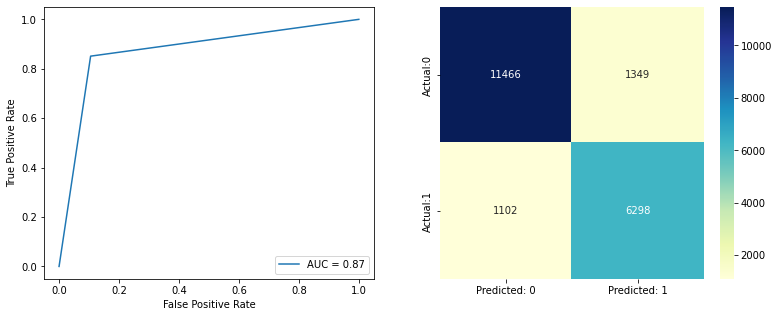

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots(1,2, figsize = (13,5))
fpr, tpr, threshold = roc_curve(raw_val_short["label"], class_preds)
roc_auc = auc(fpr, tpr)
Display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
Display.plot(ax = ax[0])

cm = confusion_matrix(raw_val_short["label"], class_preds, labels=[0,1])
cm_matrix = pd.DataFrame(data=cm, columns=["Predicted: 0",'Predicted: 1'], index=['Actual:0','Actual:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', ax = ax[1])

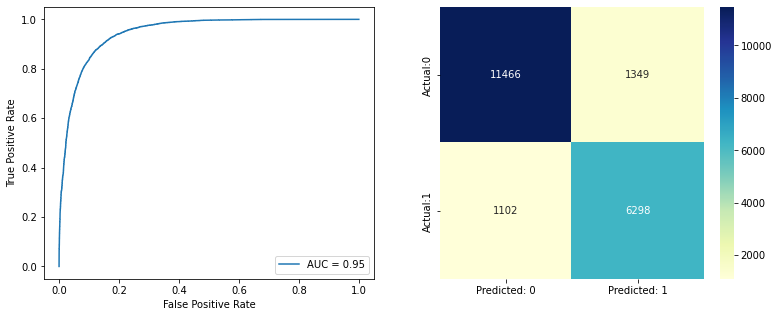

In [ ]:
#get nice roc curve with predicting probabiltiy instead of binary
preds_prob = np.exp(preds) / (1 + np.exp(preds))
preds_idx = np.argmax(preds_prob, axis=1)
combined = list(zip(preds_prob, preds_idx))
probs = []
for pred, idx in combined:
  if idx == 0: probs.append(1- pred[idx])
  else: probs.append(pred[idx])

fig, ax = plt.subplots(1,2, figsize = (13,5))
fpr, tpr, threshold = roc_curve(raw_val_short["label"], probs)
roc_auc = auc(fpr, tpr)
Display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
Display.plot(ax = ax[0])

#confusion matrix is good, so lets keep it
cm = confusion_matrix(raw_val_short["label"], class_preds, labels=[0,1])
cm_matrix = pd.DataFrame(data=cm, columns=["Predicted: 0",'Predicted: 1'], index=['Actual:0','Actual:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', ax = ax[1])

#Cats and Dogs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import array_to_img
import matplotlib.pyplot as plt

In [3]:
img = load_img("/content/drive/MyDrive/cats_and_dogs_small/test/cat/cat.1500.jpg")
arr = img_to_array(img)

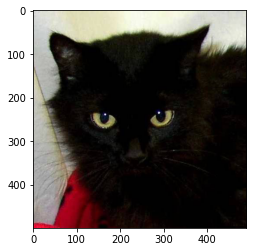

In [90]:
plt.imshow(img) #cute :)

In [4]:
#function to get images
from os import listdir
def loadImages(path): #modified from stackoverflow: https://stackoverflow.com/questions/36774431/how-to-load-images-from-a-directory-on-the-computer-in-python
    # return array of images
    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = load_img(path + "/" + image)
        loadedImages.append(img)
    return loadedImages

In [5]:
#load all images and create data splits
test_cat = loadImages("/content/drive/MyDrive/cats_and_dogs_small/test/cat")
test_dog = loadImages("/content/drive/MyDrive/cats_and_dogs_small/test/dog")
train_cat = loadImages("/content/drive/MyDrive/cats_and_dogs_small/train/cat")
train_dog = loadImages("/content/drive/MyDrive/cats_and_dogs_small/train/dog")
val_cat = loadImages("/content/drive/MyDrive/cats_and_dogs_small/validation/cat")
val_dog = loadImages("/content/drive/MyDrive/cats_and_dogs_small/validation/dog")

test_img = test_cat + test_dog
train_img = train_cat + train_dog
val_img = val_cat + val_dog

In [8]:
import tensorflow as tf

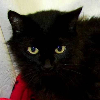

In [94]:
shaped = tf.image.resize(arr, (100, 100)) 
array_to_img(shaped) #certainly smaller

In [9]:
#turn all images into reshaped arrays
import numpy as np
def get_array_reshaped(input):
  output = []
  for i in input:
    x = img_to_array(i)
    output.append(tf.image.resize(x, (100, 100)))
  return np.array(output)
  
test_arr = get_array_reshaped(test_img)
train_arr = get_array_reshaped(train_img)
val_arr = get_array_reshaped(val_img)

In [10]:
len(train_arr), len(test_arr), len(val_arr)

(2000, 1000, 1000)

In [11]:
train_labels = np.array(len(train_cat) * [0] + len(train_dog) * [1]) #0 = cats, 1 = dogs
test_labels = np.array(len(test_cat) * [0] + len(test_dog) * [1])
val_labels = np.array(len(val_cat) * [0] + len(val_dog) * [1])

In [14]:
#Copied from task notebook
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(100, 100, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [13]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [23]:
#adjusted a little from the original notebook (a lot faster with GPU accel)
early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience = 5,
        restore_best_weights = True
        )
history = model.fit(
    x = train_arr, y = train_labels, 
    epochs=30,
    validation_data= [val_arr, val_labels],
    callbacks=early_stop)


Epoch 1/30
63/63 [==============================] - 14s 28ms/step - loss: 0.7257 - accuracy: 0.5065 - val_loss: 0.6915 - val_accuracy: 0.5180
Epoch 2/30
63/63 [==============================] - 1s 19ms/step - loss: 0.6960 - accuracy: 0.5530 - val_loss: 0.6680 - val_accuracy: 0.6440
Epoch 3/30
63/63 [==============================] - 1s 18ms/step - loss: 0.6697 - accuracy: 0.6115 - val_loss: 0.6727 - val_accuracy: 0.5730
Epoch 4/30
63/63 [==============================] - 1s 18ms/step - loss: 0.6232 - accuracy: 0.6610 - val_loss: 0.6430 - val_accuracy: 0.6240
Epoch 5/30
63/63 [==============================] - 1s 18ms/step - loss: 0.5858 - accuracy: 0.6965 - val_loss: 0.6606 - val_accuracy: 0.6110
Epoch 6/30
63/63 [==============================] - 1s 18ms/step - loss: 0.5202 - accuracy: 0.7390 - val_loss: 0.6812 - val_accuracy: 0.6800
Epoch 7/30
63/63 [==============================] - 1s 18ms/step - loss: 0.4615 - accuracy: 0.7770 - val_loss: 0.5965 - val_accuracy: 0.7030
Epoch 8/30
6

In [12]:
def plot(fit, NN_preds):
    """return the final confusion matrix, loss plot and accuracy"""
    max_acc = max(fit.history["val_accuracy"])
    max_acc_index = fit.history["val_accuracy"].index(max_acc)
    print(f"best validation accuracy was found at {max_acc} on epoch {max_acc_index}")

    fig, ax = plt.subplots(1, 3, figsize = (30,8))

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(test_labels, NN_preds, labels=[0,1])
    import pandas as pd
    cm_matrix = pd.DataFrame(data=cm, columns=["Predicted: Cat",'Predicted: Dog'], index=['Actual: Cat','Actual: Dog'])
    import seaborn as sns
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', ax = ax[0])
    ax[0].set_title("Confusion Matrix on test set")

    loss = fit.history["loss"]
    test_loss = fit.history["val_loss"]
    epochs = range(1, len(loss)+1)
    sns.lineplot(x = epochs, y = loss, color = "b", label = "Training loss", ax = ax[1])
    sns.lineplot(x = epochs, y = test_loss, color = "g", label = "Test loss", ax = ax[1])
    ax[1].set_title("Loss and validation loss")

    train_acc = fit.history["accuracy"]
    test_acc = fit.history["val_accuracy"]
    sns.lineplot(x = epochs, y =train_acc, color = "b", label = "Training accuracy", ax = ax[2])
    sns.lineplot(x = epochs, y = test_acc, color = "g", label = "Testing accuracy", ax = ax[2])
    ax[2].axhline(max_acc, color = "r", label = f"Maximum Testing Accuracy = {round(max_acc,3)}")
    plt.legend()
    ax[2].set_title("Accuracy and validation accuracy")

best validation accuracy was found at 0.7149999737739563 on epoch 10


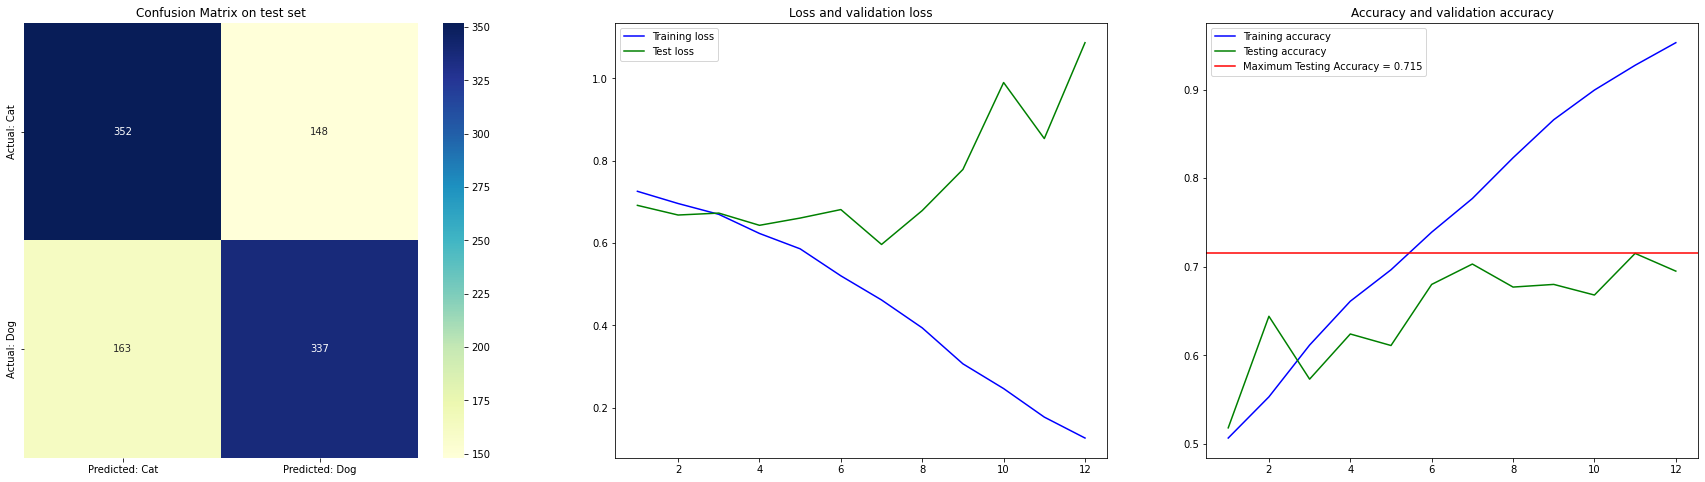

In [43]:
NN_preds = model.predict(test_arr)
preds_rounded = np.round(NN_preds)
plot(history, preds_rounded)

## Image data augmentation

In [15]:
#Data Augmentation will result in more training data and (hopefully) more stable results
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [18]:
#How about we get 10.000 extra images
train_new = train_arr
tr_labels_new = train_labels
augs = []
for i in range(5): #does 2000 images every time
  augmented_image = data_augmentation(train_arr)
  train_new = np.concatenate((train_new, augmented_image))
  #train_new + list(augmented_image) #append augmented images to new train data
  tr_labels_new = np.concatenate((tr_labels_new, train_labels))
  #tr_labels_new = tr_labels_new + list(train_labels) #just append train_labels every time since order remains the same
len(tr_labels_new), len(train_new)

(12000, 12000)

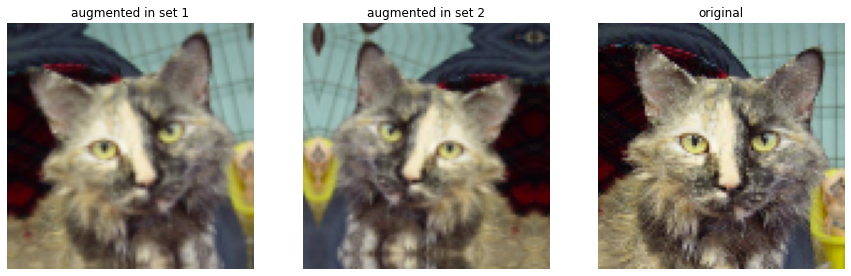

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (15,5))
ax[0].imshow(train_new[2000].astype("uint8"))
ax[0].set_title("augmented in set 1")
ax[0].axis("off");
ax[1].imshow(train_new[4000].astype("uint8"))
ax[1].set_title("augmented in set 2")
ax[1].axis("off");
ax[2].imshow(train_new[0].astype("uint8"))
ax[2].set_title("original")
ax[2].axis("off");
#maybe the augmentations are too similar, but lets try

In [122]:
#fit same NN on the bigger train data
#Copied from task notebook
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(100, 100, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
#adjusted a little from the original notebook (a lot faster with GPU accel)
early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience = 10,
        restore_best_weights = True
        )
history = model.fit(
    x = np.array(train_new), y = np.array(tr_labels_new), 
    epochs=30,
    validation_data= [val_arr, val_labels],
    callbacks=early_stop)
#this bring google collab ram to the limit

Epoch 1/30
375/375 [==============================] - 17s 16ms/step - loss: 0.6608 - accuracy: 0.6003 - val_loss: 0.9165 - val_accuracy: 0.5280
Epoch 2/30
375/375 [==============================] - 6s 15ms/step - loss: 0.5580 - accuracy: 0.7111 - val_loss: 0.6770 - val_accuracy: 0.6310
Epoch 3/30
375/375 [==============================] - 6s 15ms/step - loss: 0.4721 - accuracy: 0.7733 - val_loss: 0.5291 - val_accuracy: 0.7590
Epoch 4/30
375/375 [==============================] - 6s 15ms/step - loss: 0.3909 - accuracy: 0.8253 - val_loss: 0.5873 - val_accuracy: 0.7440
Epoch 5/30
375/375 [==============================] - 6s 15ms/step - loss: 0.3022 - accuracy: 0.8658 - val_loss: 0.7068 - val_accuracy: 0.7500
Epoch 6/30
375/375 [==============================] - 6s 17ms/step - loss: 0.2274 - accuracy: 0.9048 - val_loss: 0.9217 - val_accuracy: 0.7210
Epoch 7/30
375/375 [==============================] - 6s 16ms/step - loss: 0.1640 - accuracy: 0.9349 - val_loss: 1.1327 - val_accuracy: 0.713

best validation accuracy was found at 0.7590000033378601 on epoch 2


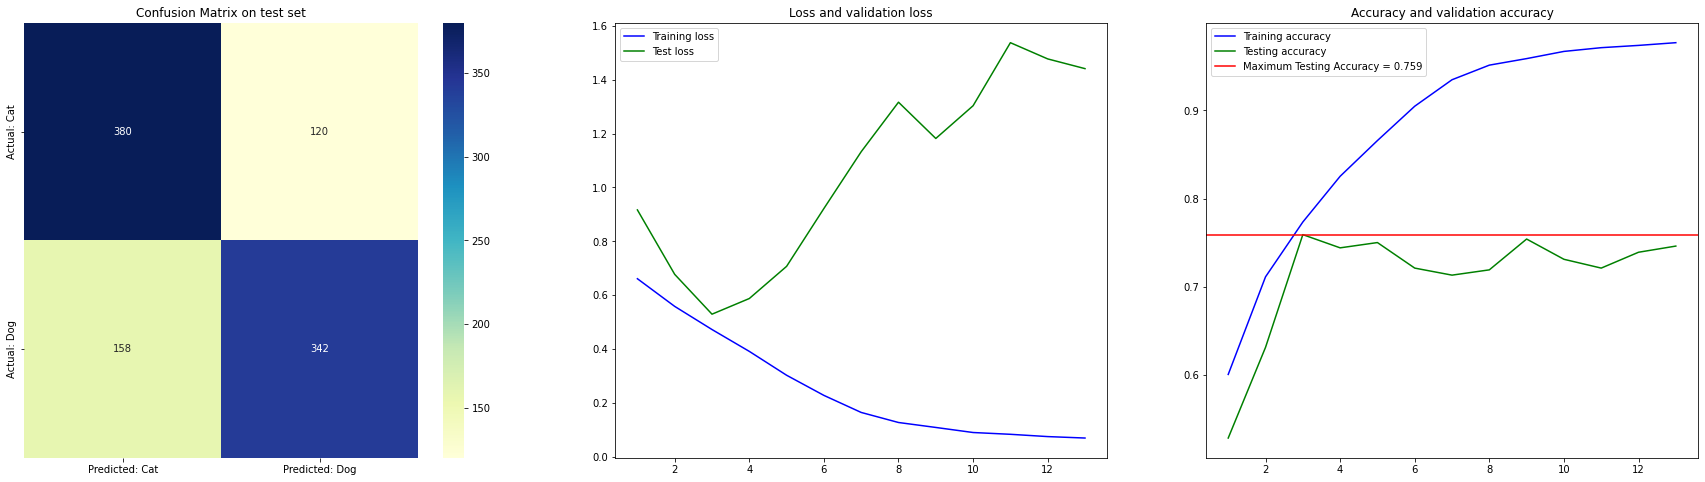

In [21]:
NN_preds = model.predict(test_arr)
preds_rounded = np.round(NN_preds)
plot(history, preds_rounded) #boosted accuracy by > 4% !

## Pretrained model

In [20]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(100, 100, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [24]:
preprocessed_images = keras.applications.vgg16.preprocess_input(train_new)
train_features = conv_base.predict(preprocessed_images)

preprocessed_images = keras.applications.vgg16.preprocess_input(val_arr)
val_features = conv_base.predict(preprocessed_images)

preprocessed_images = keras.applications.vgg16.preprocess_input(test_arr)
test_features = conv_base.predict(preprocessed_images)

In [26]:
train_features.shape, val_features.shape

((12000, 3, 3, 512), (1000, 3, 3, 512))

In [28]:
#lets fit with these features
#build model
inputs = keras.Input(shape=(3, 3, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience = 10,
        restore_best_weights = True
        )

history = model.fit(
    train_features, np.array(tr_labels_new),
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=early_stop)

Epoch 1/20
375/375 [==============================] - 2s 4ms/step - loss: 8.7109 - accuracy: 0.8848 - val_loss: 3.3793 - val_accuracy: 0.8890
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 0.8213 - accuracy: 0.9202 - val_loss: 0.7618 - val_accuracy: 0.8940
Epoch 3/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3865 - accuracy: 0.9327 - val_loss: 0.6404 - val_accuracy: 0.9120
Epoch 4/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3797 - accuracy: 0.9429 - val_loss: 1.1092 - val_accuracy: 0.8910
Epoch 5/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3613 - accuracy: 0.9517 - val_loss: 1.1111 - val_accuracy: 0.9060
Epoch 6/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3545 - accuracy: 0.9588 - val_loss: 0.9664 - val_accuracy: 0.9210
Epoch 7/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3420 - accuracy: 0.9640 - val_loss: 1.6791 - val_accuracy: 0.9070
Epoch 

best validation accuracy was found at 0.9240000247955322 on epoch 8


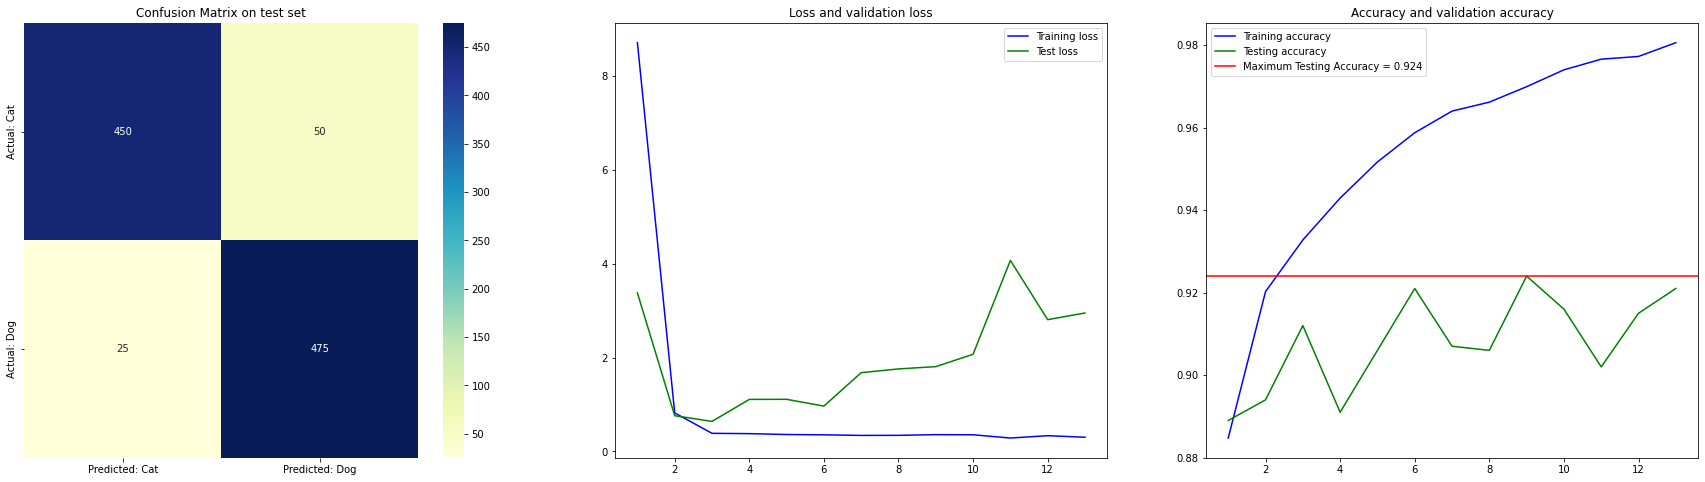

In [30]:
NN_preds = model.predict(test_features)
preds_rounded = np.round(NN_preds)
plot(history, preds_rounded) #boosted accuracy by > 16%

In [31]:
#victory lap
#build model
inputs = keras.Input(shape=(3, 3, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

opt = tf.keras.optimizers.RMSprop(learning_rate = 0.00001) #this is new (because it overfitted so quickly)
model.compile(loss="binary_crossentropy",
              optimizer= opt,
              metrics=["accuracy"])

early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience = 15,
        restore_best_weights = True
        )

history = model.fit(
    train_features, np.array(tr_labels_new),
    epochs=50,
    validation_data=(val_features, val_labels),
    callbacks=early_stop)

Epoch 1/50
375/375 [==============================] - 2s 4ms/step - loss: 4.6542 - accuracy: 0.7706 - val_loss: 1.6088 - val_accuracy: 0.8840
Epoch 2/50
375/375 [==============================] - 1s 3ms/step - loss: 2.6328 - accuracy: 0.8557 - val_loss: 1.3602 - val_accuracy: 0.9110
Epoch 3/50
375/375 [==============================] - 1s 3ms/step - loss: 1.9295 - accuracy: 0.8848 - val_loss: 1.3687 - val_accuracy: 0.9160
Epoch 4/50
375/375 [==============================] - 1s 3ms/step - loss: 1.6738 - accuracy: 0.8949 - val_loss: 1.3415 - val_accuracy: 0.9150
Epoch 5/50
375/375 [==============================] - 1s 3ms/step - loss: 1.3834 - accuracy: 0.9061 - val_loss: 1.3470 - val_accuracy: 0.9200
Epoch 6/50
375/375 [==============================] - 1s 3ms/step - loss: 1.2483 - accuracy: 0.9125 - val_loss: 1.3735 - val_accuracy: 0.9200
Epoch 7/50
375/375 [==============================] - 1s 3ms/step - loss: 1.0406 - accuracy: 0.9206 - val_loss: 1.3479 - val_accuracy: 0.9200
Epoch 

best validation accuracy was found at 0.9229999780654907 on epoch 8


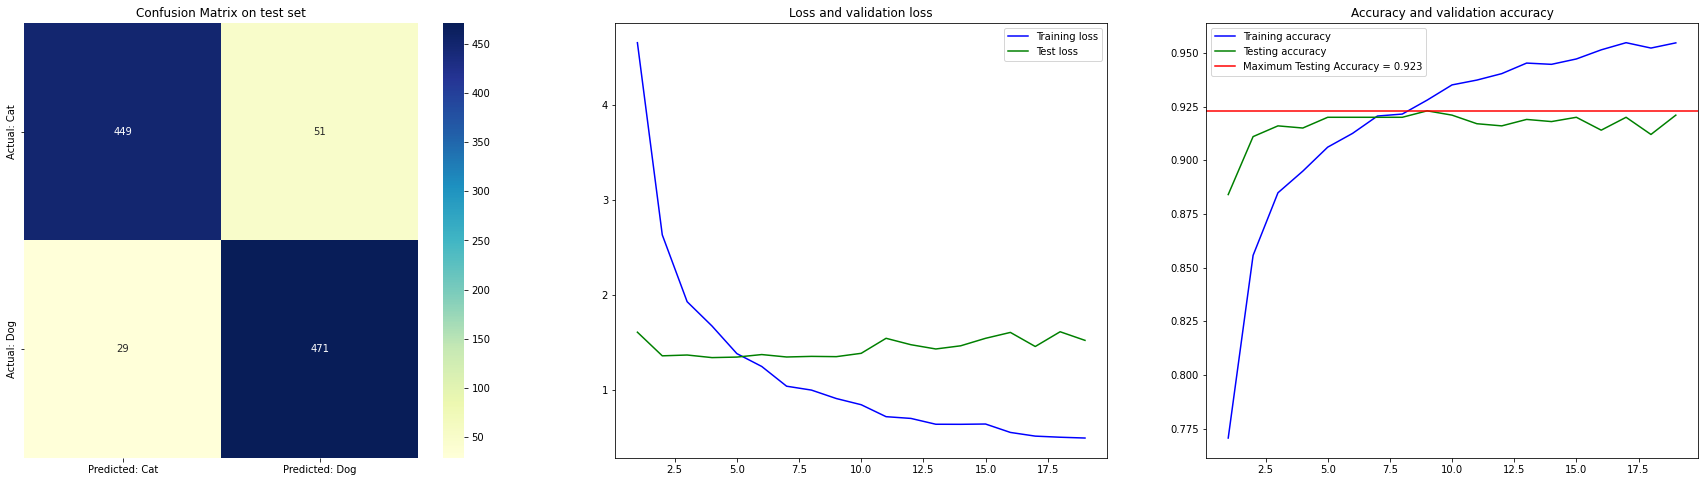

In [32]:
NN_preds = model.predict(test_features)
preds_rounded = np.round(NN_preds)
plot(history, preds_rounded) #results are the same, but curves look a little better

In [35]:
#victory lap2
#build model
inputs = keras.Input(shape=(3, 3, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0000001) #this is new (because it still overfitted so quickly)
model.compile(loss="binary_crossentropy",
              optimizer= opt,
              metrics=["accuracy"])

early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience = 20,
        restore_best_weights = True
        )

history = model.fit(
    train_features, np.array(tr_labels_new),
    epochs=500,
    validation_data=(val_features, val_labels),
    callbacks=early_stop)

Epoch 1/500
375/375 [==============================] - 2s 4ms/step - loss: 27.2764 - accuracy: 0.3914 - val_loss: 21.3276 - val_accuracy: 0.3410
Epoch 2/500
375/375 [==============================] - 1s 3ms/step - loss: 25.9775 - accuracy: 0.4070 - val_loss: 19.5912 - val_accuracy: 0.3590
Epoch 3/500
375/375 [==============================] - 1s 3ms/step - loss: 24.3351 - accuracy: 0.4202 - val_loss: 17.9942 - val_accuracy: 0.3830
Epoch 4/500
375/375 [==============================] - 1s 3ms/step - loss: 23.2037 - accuracy: 0.4310 - val_loss: 16.5068 - val_accuracy: 0.4010
Epoch 5/500
375/375 [==============================] - 1s 3ms/step - loss: 21.7102 - accuracy: 0.4463 - val_loss: 15.1505 - val_accuracy: 0.4280
Epoch 6/500
375/375 [==============================] - 1s 3ms/step - loss: 20.6061 - accuracy: 0.4603 - val_loss: 13.9067 - val_accuracy: 0.4480
Epoch 7/500
375/375 [==============================] - 1s 3ms/step - loss: 19.5305 - accuracy: 0.4622 - val_loss: 12.7534 - val_ac

In [1]:
#just before I wanted to plot this, my GPU runtime ran out. it is what it is
NN_preds = model.predict(test_features)
preds_rounded = np.round(NN_preds)
plot(history, preds_rounded) #results are worse, probably increase learning rate to something inbetween

NameError: ignored